<h1 align='center'>Transformación y Selección de variables</h1>

In [2]:
%load_ext autoreload
%autoreload 2
# Gestion de rutas
import utils.paths as path
# Importacion de librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os
import re
# Directorio de los datos crudos / raw data
raw_data_dir = path.make_dir_function(['datasets', 'raw'])
proc_data_dir = path.make_dir_function(['datasets', 'processed'])
inte_data_dir = path.make_dir_function(['datasets', 'interim'])

In [25]:
# Usando la data provicional | Lectura del dataset
noise_pollution = pd.read_parquet(inte_data_dir('noise_pollution.parquet'))

In [26]:
def replace_negatives_ones(df, cols):
    for col in cols:
        df[col] = df[col].replace(-1,1)
    return df

In [27]:
noise_pollution_v1 = replace_negatives_ones(noise_pollution, noise_pollution.loc[::,'small_sounding_engine':'unknown_alert_signal'].columns)
print(f"Las columnas que se transformarán son:\n> {[i for i in noise_pollution.loc[::,'small_sounding_engine':'unknown_alert_signal'].columns]}")

Las columnas que se transformarán son:
> ['small_sounding_engine', 'medium_sounding_engine', 'large_sounding_engine', 'uncertain_size_engine', 'car_horn', 'car_alarm', 'siren', 'reverse_beeper', 'unknown_alert_signal']


Creamos dos nuevas variables ``engine_sound_pres`` y ``alert_signal_pres`` que resumen la cantidad total de registros de sonidos provenientes del motor del vehículo y señales de alarma, respectivamente. Para la primera variable se han considerado las columnas ``'small_sounding_engine', 'medium_sounding_engine', 'large_sounding_engine', 'uncertain_size_engine'`` y para la segunda ``'car_horn', 'car_alarm', 'siren', 'reverse_beeper', 'unknown_alert_signal'``.

In [28]:
def summary_sound_presence(df: pd.DataFrame , cols: dict, new_col_name:str):
    df[new_col_name] = df[cols].sum(axis=1)
    df = df.drop(cols, axis=1)
    return df

In [29]:
noise_pollution_v1 = summary_sound_presence(noise_pollution_v1, ['car_horn', 'car_alarm', 'siren', 'reverse_beeper', 'unknown_alert_signal'],'alert_signal_pres')
noise_pollution_v1 = summary_sound_presence(noise_pollution_v1, ['small_sounding_engine', 'medium_sounding_engine', 'large_sounding_engine', 'uncertain_size_engine'],'engine_sound_pres')

In [30]:
noise_pollution_v1.head(1)

,borough,block,latitude,longitude,year,week,day,hour,date,alert_signal_pres,engine_sound_pres
0,manhattan,547,40.72951,-73.99388,2019,43,4,8,2019-10-31 08:00:00,5,4


In [31]:
# Generamos la columna month correpondiente a los meses
noise_pollution_v1['month'] = noise_pollution_v1['date'].dt.month
# Eliminar la variable block, week, date, hour, latitude, longitude
noise_pollution_v1 = noise_pollution_v1.drop(['block','week','date', 'hour','latitude','longitude'], axis=1)

In [41]:
# Reordenando las variables
noise_pollution_v1 = noise_pollution_v1.loc[::, ['borough', 'year', 'month', 'day', 'alert_signal_pres', 'engine_sound_pres']]

In [44]:
# Probabilidad de escuchar un ruido/sonido en un determinado Borough proveniente de sonidos de automóviles y señales de alerta cada día.
noise_pollution_v2 = (noise_pollution_v1.groupby(['borough', 'year','month','day']).sum().loc[::,'alert_signal_pres':'engine_sound_pres']/24)*100
noise_pollution_v2 = noise_pollution_v2.reset_index()

In [46]:
# Funcion que reemplaza: 1: 'manhattan': 1, 'Brooklyn':3 y 'Queens': 4
def replace_id_borough_by_borough(df: pd.DataFrame, colname: str, new_colname: str):
    borough = {
        'manhattan': 1,
        'bronx': 2,
        'rooklyn': 3,
        'queens': 4,
        'staten island': 5,
    }
    df[new_colname] = df[colname].replace(borough)
    return df

In [47]:
# Reemplazo de los nombres de borough por el id correspondiente
noise_pollution_v2 = replace_id_borough_by_borough(noise_pollution_v2, 'borough', 'borough_id')

In [50]:
noise_pollution_v2

,borough,year,month,day,alert_signal_pres,engine_sound_pres,borough_id
0,manhattan,2016,1,0,29.166667,62.500000,1
1,manhattan,2016,5,0,95.833333,83.333333,1
2,manhattan,2016,5,1,12.500000,20.833333,1
3,manhattan,2016,5,2,58.333333,37.500000,1
4,manhattan,2016,5,3,12.500000,16.666667,1
...,...,...,...,...,...,...,...
502,rooklyn,2019,12,2,208.333333,133.333333,3
503,rooklyn,2019,12,3,379.166667,283.333333,3
504,rooklyn,2019,12,4,150.000000,133.333333,3
505,rooklyn,2019,12,5,125.000000,100.000000,3


## Data Procesada

**Descripción de las variables de la tabla**

|        Columns        |                                                                                                                                     Description                                                                                                                                     |  type |
|:---------------------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:-----:|
|        borough        | The NYC borough name in which the sensor is located (Manhattan, Brooklyn, Queens).                                                                                                                                                                                                  |  str  |
|          year         | The year the recording is from.                                                                                                                                                                                                                                                     |  int  |
|         month         | The month of the week the recording is from, with January as the start (i.e. 1=January).                                                                                                                                                                                            |  int  |
|          day          | The day of the week the recording is from, with Monday as the start (i.e. 0=Monday).                                                                                                                                                                                                |  int  |
| avg_engine_sound_prob | Average probability of recording a sound that comes from a small engine, medium engine,  large engine, or any engine sound in the vehicle whose sound size cannot be determined with certainty.                                                                                     | float |
| avg_alert_signal_prob | Average probability of recording a sound that comes from a horn or honk, anti-theft alarm,  emergency vehicle sirens like ambulances and patrol cars, reverse signaling devices, and any  other type of alert signal in the vehicle whose type cannot be determined with certainty. | float |
|       borough_id      | The NYC borough in which the sensor is located (1=Manhattan, 3=Brooklyn, 4=Queens). This corresponds to the first digit in the 10-digit NYC parcel number system known as Borough, Block, Lot (BBL).                                                                                |  int  |

* **borough**: The NYC borough name in which the sensor is located (Manhattan, Brooklyn, Queens).
* **year**: The year the recording is from.
* **month**: The month of the week the recording is from, with January as the start (i.e. 1=January).
* **day**: The day of the week the recording is from, with Monday as the start (i.e. 0=Monday).
* **avg_engine_sound_prob**: Average probability of recording a sound that comes from a small engine, medium engine, large engine, or any engine sound in the vehicle whose sound size cannot be determined with certainty.
* **avg_alert_signal_prob**: Average probability of recording a sound that comes from a horn or honk, anti-theft alarm, emergency vehicle sirens like ambulances and patrol cars, reverse signaling devices, and any other type of alert signal in the vehicle whose type cannot be determined with certainty.
* **borough_id**: The NYC borough in which the sensor is located (1=Manhattan, 3=Brooklyn, 4=Queens). This corresponds to the first digit in the 10-digit NYC parcel number system known as Borough, Block, Lot (BBL).

In [52]:
# Exportamos la data procesada
noise_pollution_v2.to_csv(proc_data_dir('noise_pollution.csv'))

### Probabilidad de escuchar ruidos y sonidos en distintos barrios de la ciudad

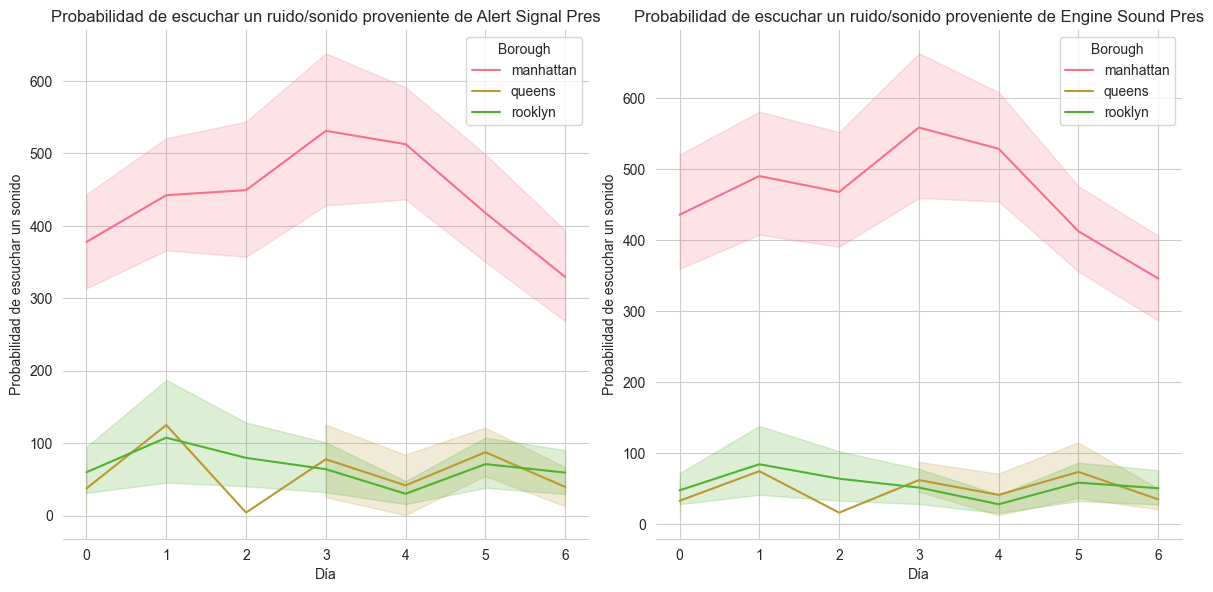

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# definir el número de filas y columnas para organizar las gráficas
num_cols = 2
num_rows = (len(noise_pollution_v2.columns[4:-1]) + 1) // 2

# definir el tamaño de la figura
fig, axs = plt.subplots(ncols=num_cols, figsize=(12,6))

# iterar por cada columna y graficar en un subplot diferente
for i, col in enumerate(noise_pollution_v2.columns[4:-1]):
    # seleccionar el subplot correspondiente
    ax = axs[i % 2]

    # crear el gráfico de líneas apiladas
    sns.set_style('whitegrid')
    sns.set_palette('husl')
    sns.lineplot(data=noise_pollution_v2, x='day', y=f'{col}', hue='borough', ax=ax)

    # personalizar el gráfico
    sns.despine(left=True, ax=ax)
    # Probabilidad de escuchar un ruido/sonido en un determinado Borough proveniente de sonidos de automóviles y señales de alerta cada día
    ax.set_title(f"Probabilidad de escuchar un ruido/sonido proveniente de {col.replace('_', ' ').title()}")
    ax.set_xlabel('Día')
    ax.set_ylabel('Probabilidad de escuchar un sonido')
    ax.legend(title='Borough', loc='upper right')

    if i % 2 != 0:
        # ajustar los subplots
        fig.tight_layout(pad=1.0)
        plt.show()

# ajustar los subplots y mostrar la figura
if len(noise_pollution_v2.columns[4:-1]) % 2 == 1:
    axs[-1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()